<a href="https://colab.research.google.com/github/DandyYahmin/Learn-Data-Analytics/blob/main/Sales_Analysis_%26_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pendahuluan**


Tujuan utama adalah untuk menganalisis dan memahami pola penjualan & tren musiman berdasarkan dataset.

## **Isi:**

Dataset ini mencakup semua transaksi dari sebuah perusahaan ritel online yang berbasis di Inggris selama periode 1 Desember 2010 hingga 9 Desember 2011. Perusahaan ini fokus pada penjualan hadiah unik untuk berbagai kesempatan, dengan sebagian besar pelanggannya adalah grosir.

referensi data: https://www.kaggle.com/datasets/carrie1/ecommerce-data

# **Mengimpor library & Memuat data**

In [6]:
!pip install catboost

In [7]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.cluster import KMeans

In [8]:
data = pd.read_csv('data.csv', encoding='latin-1')

# **Eksplorasi data**


### Hal yang Kami Verifikasi:
Kolom 'InvoiceDate' diubah dari tipe string menjadi objek datetime (diubah pada saat pembersihan data). Jumlah nilai nol dan nilai yang hilang yang terdapat dalam dataset.

In [9]:
data.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [10]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


# **Menampilkan nilai yang hilang**

Menampilkan kolom yang mengandung setidaknya satu nilai 0 (nol).

In [11]:
data.columns[data.isin([0]).any()]

Index(['UnitPrice'], dtype='object')

Menampilkan kolom yang berisi setidaknya satu nilai yang hilang (NaN)

In [12]:
data.columns[data.isna().any()]

Index(['Description', 'CustomerID'], dtype='object')

Menampilkan jumlah nilai yang hilang (NaN) di setiap kolom DataFrame

In [13]:
data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


# **Pembersihan data**

Mengganti nilai 0 dengan mean

In [14]:
unit_price_mean = data['UnitPrice'].mean() #Menghitung mean di kolom 'UnitPrice'
data['UnitPrice'] = data['UnitPrice'].replace(0, unit_price_mean)

Isi nilai yang hilang di kolom 'Deskripsi' dengan teks 'Deskripsi tidak tersedia'

In [15]:
data['Description'].fillna('Deskripsi tidak tersedia')
data.isna().sum() # menampilkan berapa banyak nilai yang hilang yang tersisa di setiap kolom DataFrame

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Mengubah kolom 'InvoiceDate' menjadi datetime

In [16]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.info() # Menampilkan tipe data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# **Analisis Penjualan dan Produk**

## Penjualan berdasarkan kategori produk

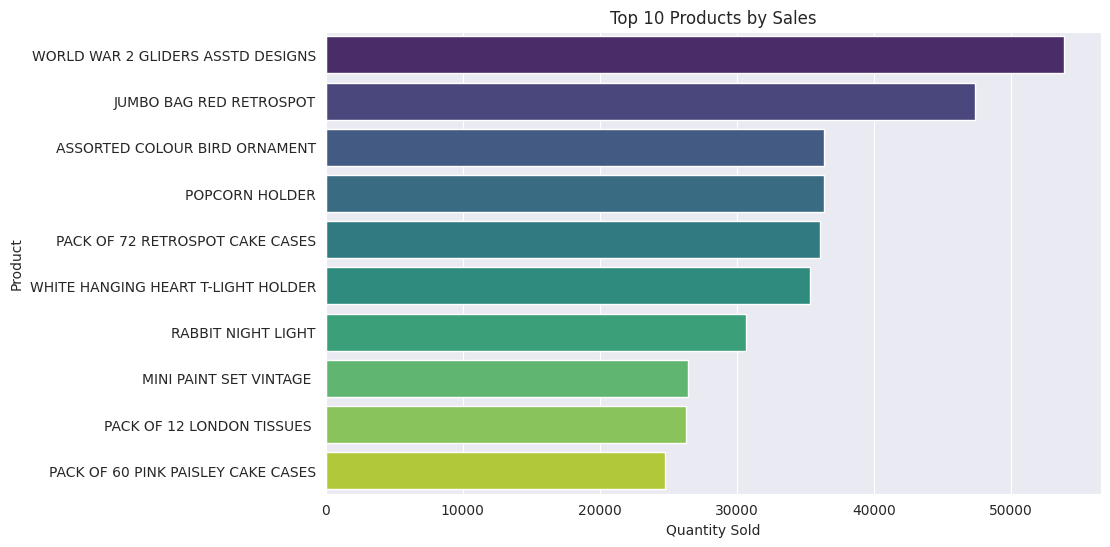

In [17]:
sales_by_product = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_product.values, y=sales_by_product.index, palette='viridis')
plt.xlabel('Quantity Sold')
plt.ylabel('Product')
plt.title('Top 10 Products by Sales')
plt.show()

### 1. Produk Terlaris:
**"WORLD WAR 2 GLIDERS ASSTD DESIGNS"** dan **"JUMBO BAG RED RETROSPOT"** adalah dua produk terlaris, menunjukkan permintaan tinggi untuk barang-barang ini.

### 2. Volume Penjualan Signifikan:
Produk-produk ini telah terjual dalam jumlah yang jauh lebih besar dibandingkan dengan produk lainnya, mengindikasikan popularitas yang tinggi di kalangan pelanggan.

### 3. Ragam Produk:
Daftar ini mencakup berbagai macam produk seperti ornamen, wadah, lampu malam, dan berbagai barang bertema, yang mencerminkan portofolio produk yang luas.

### 4. Kategori Populer:
Barang-barang yang berhubungan dengan desain retro dan tema unik (misalnya, **"PACK OF 72 RETROSPOT CAKE CASES"**) tampaknya memiliki performa baik, yang mungkin menunjukkan preferensi pelanggan terhadap barang-barang vintage atau unik.

### 5. Implikasi Persediaan:
Mengingat volume penjualan yang tinggi, disarankan untuk menjaga persediaan yang cukup untuk produk-produk yang berkinerja baik ini untuk memenuhi permintaan pelanggan dan menghindari kehabisan stok.

## Analisis Pendapatan berdasarkan Produk

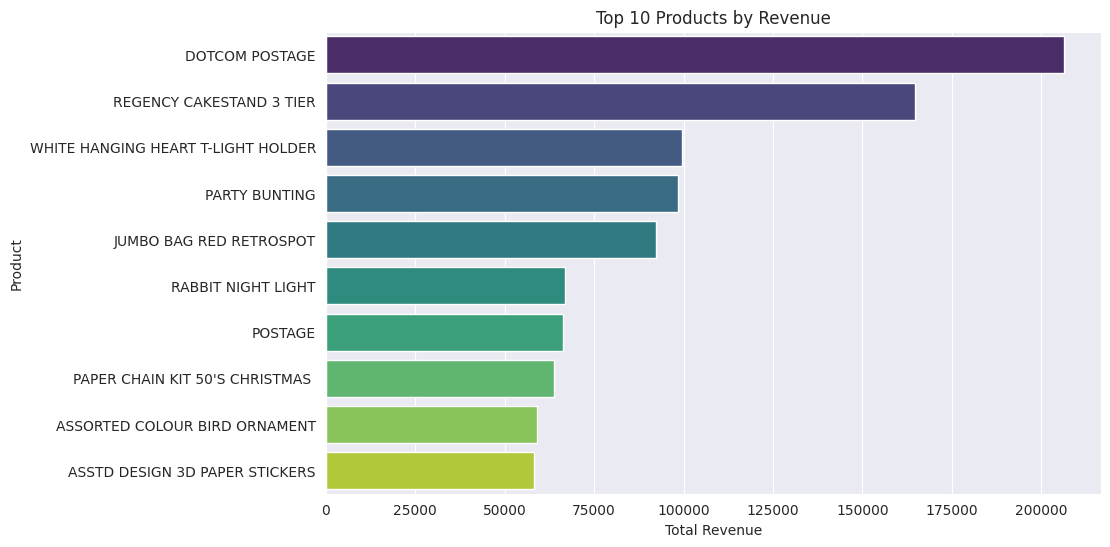

In [18]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
top_revenue_products = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_revenue_products.values, y=top_revenue_products.index, palette='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Product')
plt.title('Top 10 Products by Revenue')
plt.show()

### 1. Produk dengan Pendapatan Tertinggi:
**DOTCOM POSTAGE** adalah produk dengan pendapatan tertinggi, dengan total pendapatan yang jauh melampaui produk lainnya.
**REGENCY CAKESTAND 3 TIER** berada di urutan kedua dengan pendapatan yang juga signifikan.

### 2. Produk Lainnya dengan Pendapatan Tinggi:
Produk seperti **WHITE HANGING HEART T-LIGHT HOLDER**, **PARTY BUNTING**, dan **JUMBO BAG RED RETROSPOT** termasuk dalam kategori produk dengan pendapatan tinggi, meskipun tidak setinggi dua produk teratas.

### 3. Ragam Produk yang Menghasilkan Pendapatan:
Produk dengan berbagai macam jenis, mulai dari dekorasi rumah (seperti **WHITE HANGING HEART T-LIGHT HOLDER dan PARTY BUNTING**), peralatan pesta (seperti **PAPER CHAIN KIT 50'S CHRISTMAS**), hingga barang kebutuhan khusus (seperti **RABBIT NIGHT LIGHT**), semuanya menyumbang pendapatan yang signifikan.

### 4. Distribusi Pendapatan:
Pendapatan cenderung terdistribusi dengan baik di antara berbagai jenis produk, menunjukkan diversifikasi yang baik dalam portofolio produk.

### 5. Peluang Peningkatan:
Produk dengan pendapatan lebih rendah dalam daftar top 10, seperti **ASSORTED COLOUR BIRD ORNAMENT dan CHILLI LIGHTS**, mungkin memiliki potensi untuk ditingkatkan baik dari segi pemasaran maupun strategi penjualan.

# Tren Musiman

## Analisis Penjualan Bulanan

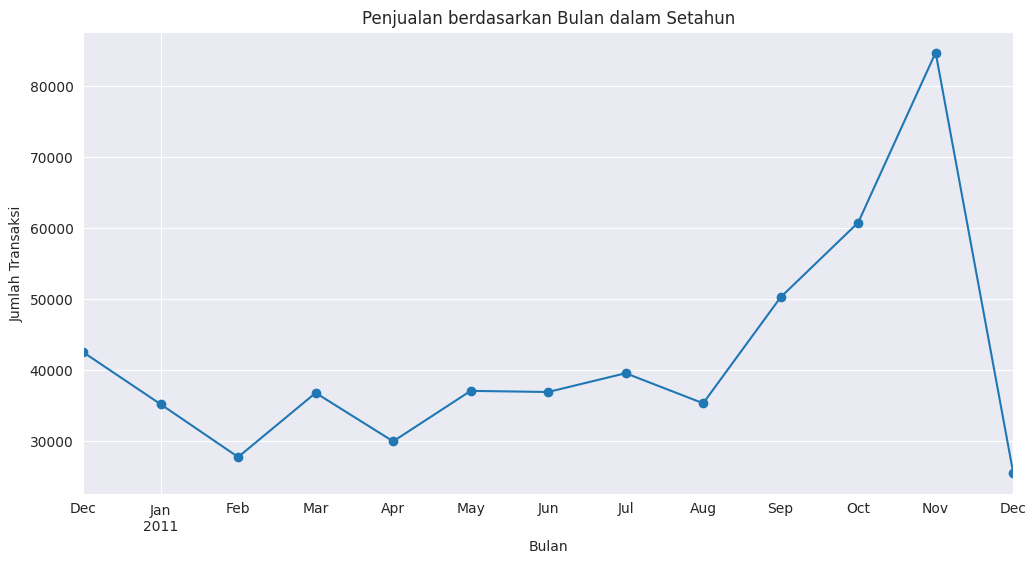

In [19]:
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')
monthly_sales = data.groupby('YearMonth').size()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Transaksi')
plt.title('Penjualan berdasarkan Bulan dalam Setahun')
plt.grid(True)
plt.show()

### 1. Peningkatan Signifikan di Bulan November:
Terjadi lonjakan penjualan yang sangat signifikan pada bulan November, dengan jumlah transaksi mencapai puncaknya. Ini kemungkinan disebabkan oleh musim belanja akhir tahun, termasuk penjualan Black Friday dan persiapan untuk liburan Natal.

### 2. Penurunan Drastis di Bulan Desember:
Setelah puncak penjualan di bulan November, jumlah transaksi turun drastis di bulan Desember. Hal ini mungkin disebabkan oleh berakhirnya musim belanja liburan dan persediaan stok yang sudah dibeli di bulan sebelumnya.

### 3. Stabilitas Penjualan di Bulan Lainnya:
Sepanjang tahun, jumlah transaksi relatif stabil dengan beberapa fluktuasi kecil. Tidak ada lonjakan signifikan selain di bulan November.

### 4. Tren Musiman:
Data menunjukkan adanya tren musiman yang kuat, terutama terkait dengan belanja akhir tahun. Ini bisa dijadikan acuan untuk strategi pemasaran dan persiapan stok di masa mendatang.

### 5. Strategi Bisnis:
Untuk memaksimalkan pendapatan, perusahaan bisa memfokuskan strategi pemasaran dan promosi pada periode sebelum November. Menyiapkan stok yang cukup untuk menghadapi lonjakan permintaan juga menjadi kunci penting.

## Analisis Penjualan Mingguan

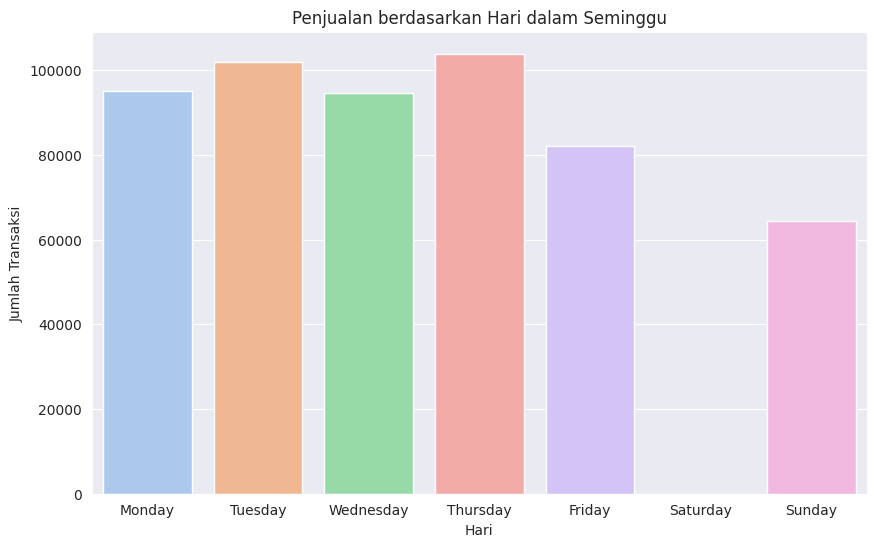

In [20]:
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
weekday_sales = data.groupby('DayOfWeek').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette='pastel')
plt.xlabel('Hari')
plt.ylabel('Jumlah Transaksi')
plt.title('Penjualan berdasarkan Hari dalam Seminggu')
plt.show()

### 1. Hari dengan Penjualan Tertinggi:
Penjualan tertinggi terjadi pada hari Selasa dan Kamis. Kedua hari ini memiliki jumlah transaksi yang hampir sama, dan keduanya lebih tinggi dibandingkan hari-hari lainnya.

### 2. Hari dengan Penjualan Terendah:
Penjualan terendah terjadi pada hari Minggu. Ini menunjukkan bahwa aktivitas penjualan berkurang signifikan pada hari tersebut.

### 3. Distribusi Penjualan di Hari Kerja:
Secara umum, penjualan cenderung tinggi dari Senin hingga Kamis, dengan sedikit penurunan pada hari Jumat.

### 4. Penurunan di Akhir Pekan:
Terdapat penurunan yang jelas dalam jumlah transaksi pada akhir pekan (Sabtu dan Minggu) dibandingkan dengan hari kerja.

# Forecasting

## Persiapan Data

In [21]:
cancelled = pd.Series(np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), 'Canceled', 'Not Canceled'))

In [22]:
def remove_outliers(column):
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    column = column[((Q1 - 1.5 * IQR) <= column) & (column  <= (Q3 + 1.5 * IQR))]
    return column

data.Quantity = remove_outliers(data.Quantity)
data.UnitPrice = remove_outliers(data.UnitPrice)

In [23]:
data.dropna(subset=['Quantity','UnitPrice'],inplace=True)
data['Revenue'] = data.Quantity * data.UnitPrice
data = data[data.Revenue>0.1]

In [24]:
cancelled = pd.Series(np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), 'Cancelled', 'Not Cancelled'))

In [25]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

In [26]:
data['InvoiceDate'] = data['InvoiceDate'].dt.date
ddate = data[['InvoiceDate','Revenue']].groupby('InvoiceDate').sum()

revenue_moving_average = ddate.rolling(
    window=150,
    center=True,
    min_periods=75,
).mean()

In [27]:
data['monthday'] = pd.to_datetime(data['InvoiceDate']).dt.day
ddate = data[['monthday','Revenue']].groupby('monthday').sum()

In [28]:
data['weakday'] = pd.to_datetime(data['InvoiceDate']).dt.dayofweek
ddate = data[['weakday','Revenue']].groupby('weakday').sum()

In [29]:
crdata = data[['Country','Revenue']].groupby('Country').mean().sort_values(by = 'Revenue', ascending = False)

In [30]:
isnull = data.isnull().sum().sort_values(ascending=False).to_frame()
isnull.columns = ['How_many']
isnull['precentage'] = np.around(((isnull / len(data) * 100)[(isnull / len(data) * 100) != 0]), decimals=2)

In [31]:
data.loc[data.Description.isnull()==False,'Description'].apply(
    lambda s: np.where("nan" in s.lower(), True, False)
    ).value_counts()

,count
Description,
False,435962
True,671


In [32]:
data.loc[data.Description.isnull()==False,'Description'] = data.loc[
    data.Description.isnull()==False,'Description'].apply(lambda s: np.where("nan" in s.lower(), np.nan, s))

In [33]:
data = data[(data.CustomerID.isnull()==False) & (data.Description.isnull()==False)].copy()

In [34]:
d = data.groupby('Description').size().to_frame().reset_index().sort_values(by=0,ascending=False).head(25)

In [35]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()

In [36]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)
data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.isocalendar().week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [37]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,12.00,10.20
1,2010-12-01,2010,4,12,48,2,335,1,10125,2.00,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5.00,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10.00,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10.00,8.50


In [38]:
daily_data.Quantity = remove_outliers(daily_data.Quantity)
daily_data.Revenue = remove_outliers(daily_data.Revenue)
daily_data.dropna(inplace=True)

## Penetapan Data

Model akan memprediksi Quantity, yang merupakan jumlah unit yang terjual setiap hari.

In [39]:
def show_me(date, true, preds):

    fig = make_subplots(rows=1, cols=1)

    fig.add_trace(go.Scatter(x=date, y=true.iloc[:,0], mode='lines',
                         marker=dict(color= '#783242'), name='Original Data'))

    fig.add_trace(go.Scatter(x=date,y=preds.iloc[:,0],mode='lines',name='Prediction'))

    fig.show()

In [49]:
X = daily_data.drop(['Date','Revenue','Quantity'],axis=1)
y = daily_data.Quantity
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2, shuffle=False)

## KNeighborsRegressor Model

In [42]:
param_grid = {'n_neighbors':list(range(3,100,2))}
m = KNeighborsRegressor()
search = GridSearchCV(m, param_grid, cv=5)
search.fit(X,y)
search.best_estimator_

KNeighborsRegressor(n_neighbors=47)

In [50]:
KNR = KNeighborsRegressor(n_neighbors=47)
KNR.fit(X_train,y_train)
KNRforecast = KNR.predict(X_valid)
f'mean squared error : {mean_squared_error(y_valid,KNRforecast)}'

'mean squared error : 37.090801737952155'

In [51]:
X_valid['forecast'] = KNRforecast

spliter = round(len(daily_data)*0.8)
X_valid['Date'] = daily_data['Date'].iloc[spliter:]
preds= X_valid[['Date','forecast']].groupby('Date').mean()
true = daily_data[['Date','Quantity']].iloc[spliter:,:].groupby('Date').mean()

show_me(true.index, true, preds)

## RandomForestRegressor Model

In [52]:
X = daily_data.drop(['Date','Revenue','Quantity'],axis=1)
y = daily_data.Quantity
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2, shuffle=False)

In [53]:
RFR = RandomForestRegressor(max_depth=20, n_estimators=100, random_state=0)
RFR.fit(X_train,y_train)
RFRforecast = RFR.predict(X_valid)
f'mean squared error : {mean_squared_error(y_valid,RFRforecast)}'

'mean squared error : 35.1581655766947'

In [54]:
X_valid['forecast'] = RFRforecast

spliter = round(len(daily_data)*0.8)
X_valid['Date'] = daily_data['Date'].iloc[spliter:]
preds= X_valid[['Date','forecast']].groupby('Date').mean()
true = daily_data[['Date','Quantity']].iloc[spliter:,:].groupby('Date').mean()

show_me(true.index, true, preds)

## CatBoostRegressor Model

In [44]:
X = daily_data.drop(['Date','Revenue','Quantity'],axis=1)
y = daily_data.Quantity
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2, shuffle=False)

In [45]:
cat_features_idx = np.where(X.dtypes != int)[0]
train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
val_pool = Pool(X_valid, y_valid, cat_features=cat_features_idx)

CBR = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=0,
    logging_level='Silent',
    iterations=1000,
    max_depth=4,
    l2_leaf_reg=3,
    od_type='Iter',
    od_wait=40,
    train_dir="baseline",
    has_time=True
)

CBR.fit(train_pool, eval_set=val_pool, plot=True)
CBRforecast = CBR.predict(X_valid)
mse = mean_squared_error(y_valid, CBRforecast)
print(f'Mean Squared Error: {mse}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mean Squared Error: 33.00059166752149


In [46]:
X_valid['forecast'] = CBRforecast

spliter = round(len(daily_data)*0.8)
X_valid['Date'] = daily_data['Date'].iloc[spliter:]
preds= X_valid[['Date','forecast']].groupby('Date').mean()
true = daily_data[['Date','Quantity']].iloc[spliter:,:].groupby('Date').mean()

show_me(true.index, true, preds)